In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install xgboost --quiet

In [3]:
import pandas as pd
import numpy as np

from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns


In [4]:
# Load the Training Dataset
data = pd.read_csv(
    '/content/drive/MyDrive/Research Project/C1/yield/coffee_yield_simulation/yield_train_dataset.csv'
)

data.head()


,year,month,district,plot_area_hectares,plants_per_hectare,variety,avg_temp,avg_humidity,total_rainfall_mm,rainy_days,avg_cloudcover,avg_solarradiation,avg_uvindex,disease_severity,baseline_yield_kg,yield_reduction_percent,adjusted_yield_kg
0,2023.0,1.0,Kandy,0.75,1948,Arabica,70.216129,86.003226,1.918,21,75.916129,182.587097,6.806452,0.326,55.62,0.3,38.93
1,2023.0,1.0,Kandy,0.25,1620,Arabica,70.216129,86.003226,1.918,21,75.916129,182.587097,6.806452,0.343,17.52,0.3,12.26
2,2023.0,1.0,Kandy,0.75,1814,Arabica,70.216129,86.003226,1.918,21,75.916129,182.587097,6.806452,0.373,52.06,0.3,36.44
3,2023.0,1.0,Kandy,0.25,1699,Arabica,70.216129,86.003226,1.918,21,75.916129,182.587097,6.806452,0.390,17.67,0.3,12.37
4,2023.0,1.0,Kandy,0.75,1749,Arabica,70.216129,86.003226,1.918,21,75.916129,182.587097,6.806452,0.396,59.89,0.3,41.92


In [5]:
# Feature Selection
TARGET = 'adjusted_yield_kg'

FEATURES = [
    'plot_area_hectares',
    'plants_per_hectare',
    'avg_temp',
    'avg_humidity',
    'total_rainfall_mm',
    'rainy_days',
    'avg_cloudcover',
    'avg_solarradiation',
    'avg_uvindex',
    'disease_severity',
    'variety'
]

X = data[FEATURES].copy()
y = data[TARGET]


In [6]:
# Encode Categorical Features
le = LabelEncoder()
X['variety'] = le.fit_transform(X['variety'])  # Arabica / Robusta


In [7]:
# Train / Validation Split
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)


In [8]:
# Define Advanced XGBoost Model
model = XGBRegressor(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    random_state=42
)


In [9]:
# Train the Model
model.fit(
    X_train,
    y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=None, num_parallel_tree=None, ...)

In [10]:
# Model Evaluation
y_pred = model.predict(X_val)

mae = mean_absolute_error(y_val, y_pred)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
r2 = r2_score(y_val, y_pred)

print(f"MAE  : {mae:.2f} kg")
print(f"RMSE : {rmse:.2f} kg")
print(f"R²   : {r2:.3f}")


MAE  : 3.78 kg
RMSE : 5.49 kg
R²   : 0.878


In [11]:
# Feature Importance (VERY IMPORTANT)
importance = model.feature_importances_
features = X.columns

imp_df = pd.DataFrame({
    'feature': features,
    'importance': importance
}).sort_values(by='importance', ascending=False)

imp_df


,feature,importance
10,variety,0.501458
0,plot_area_hectares,0.359212
8,avg_uvindex,0.021095
5,rainy_days,0.019314
7,avg_solarradiation,0.018112
3,avg_humidity,0.016565
9,disease_severity,0.015845
6,avg_cloudcover,0.015822
1,plants_per_hectare,0.011434
2,avg_temp,0.010899


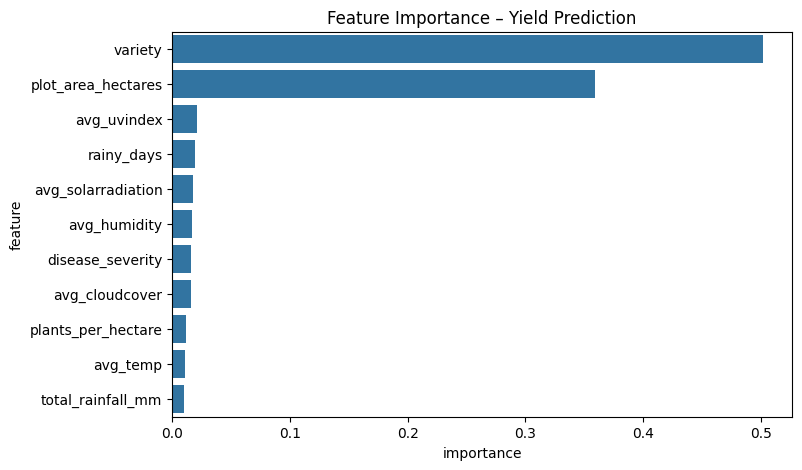

In [12]:
# Plot Feature Importance
plt.figure(figsize=(8, 5))
sns.barplot(
    x='importance',
    y='feature',
    data=imp_df
)
plt.title('Feature Importance – Yield Prediction')
plt.show()


In [13]:
# Save Trained Model
import joblib

joblib.dump(
    model,
    '/content/drive/MyDrive/Research Project/C1/yield/coffee_yield_simulation/yield_xgboost_model.pkl'
)

joblib.dump(
    le,
    '/content/drive/MyDrive/Research Project/C1/yield/coffee_yield_simulation/variety_encoder.pkl'
)

print("Model and encoder saved")


Model and encoder saved


In [14]:
# Predict Future Yields (2025–2026)
future = pd.read_csv(
    '/content/drive/MyDrive/Research Project/C1/yield/coffee_yield_simulation/yield_future_weather_dataset.csv'
)

future_X = future[FEATURES].copy()
future_X['variety'] = le.transform(future_X['variety'])

future['predicted_yield_kg'] = model.predict(future_X).round(2)

future.head()


,year,month,district,plot_area_hectares,plants_per_hectare,variety,avg_temp,avg_humidity,total_rainfall_mm,rainy_days,avg_cloudcover,avg_solarradiation,avg_uvindex,disease_severity,baseline_yield_kg,yield_reduction_percent,adjusted_yield_kg,predicted_yield_kg
0,2025.0,1.0,Kandy,0.75,1776,Arabica,69.819355,91.696774,4.67,27,69.570968,126.706452,5.032258,0.329,50.92,0.3,35.64,37.509998
1,2025.0,1.0,Kandy,0.50,1840,Arabica,69.819355,91.696774,4.67,27,69.570968,126.706452,5.032258,0.331,36.91,0.3,25.84,25.070000
2,2025.0,1.0,Kandy,0.50,1777,Arabica,69.819355,91.696774,4.67,27,69.570968,126.706452,5.032258,0.416,34.85,0.3,24.40,25.670000
3,2025.0,1.0,Kandy,0.25,1815,Robusta,69.819355,91.696774,4.67,27,69.570968,126.706452,5.032258,0.361,34.75,0.3,24.32,25.110001
4,2025.0,1.0,Kandy,0.75,1868,Arabica,69.819355,91.696774,4.67,27,69.570968,126.706452,5.032258,0.371,62.46,0.3,43.72,38.180000


In [15]:
# Save Future Predictions
future.to_csv(
    '/content/drive/MyDrive/Research Project/C1/yield/coffee_yield_simulation/yield_predictions_2025_2026.csv',
    index=False
)

print("Future yield predictions saved")


Future yield predictions saved
